## Imports necessary libraries

In [30]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Mounts Google Drive to Colab at /content/drive.

In [3]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


# Loads training and validation datasets

In [4]:
path = '/content/driver/MyDrive/MyDatasets/ComputerVision/Classification/kvasir-dataset'

In [16]:
train_dataset = image_dataset_from_directory(
    path,
    image_size = (224,224),
    batch_size = 32,
    label_mode = 'int',
    subset = "training",
    shuffle = True,
    validation_split = 0.2,
    seed = 123
)
test_dataset = image_dataset_from_directory(
    path,
    image_size = (128,128),
    batch_size = 32,
    label_mode = 'int',
    subset = "validation",
    validation_split = 0.2,
    seed = 123
)

Found 4000 files belonging to 8 classes.
Using 3200 files for training.
Found 4000 files belonging to 8 classes.
Using 800 files for validation.


# Defines a preprocessing function

In [17]:
def preprocess(image , label):
  label = to_categorical(label , num_classes = 8)
  return image , label
train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [18]:
for image , label in train_dataset.take(1):
  print(f"image shape : {image.shape}")
  print(f"label shape : {label.shape}")
  break

image shape : (32, 224, 224, 3)
label shape : (32, 8)


In [19]:
print(np.unique(sample_labels))

[0. 1.]


# Displays the first 25 images from the dataset

In [20]:
sample_images = []
sample_labels = []
count = 0
for image , label in train_dataset.take(1):
  if count == 25:
    break
  sample_images.append(image)
  sample_labels.append(label)
  count += 1

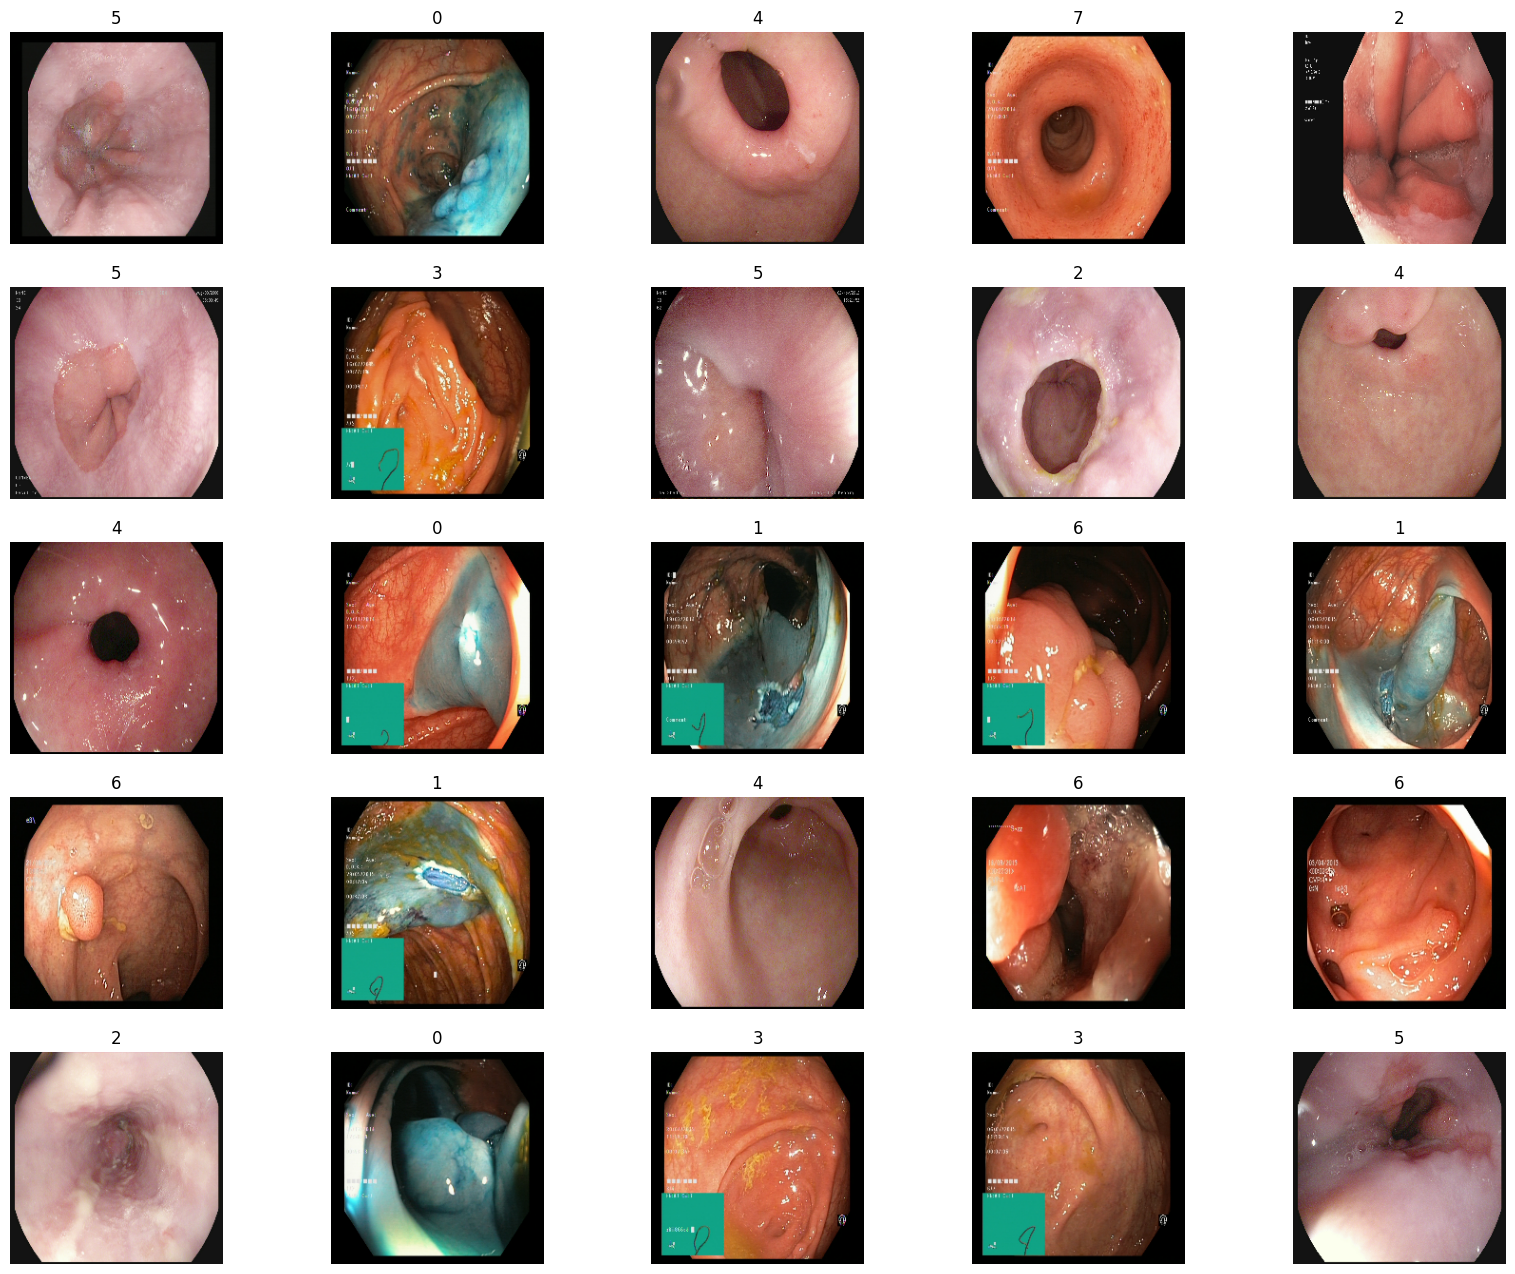

In [21]:
plt.figure(figsize = (20,16))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(sample_images[0][i].numpy().astype('uint8'))
  plt.title(np.argmax(sample_labels[0][i].numpy()))
  plt.axis("off")
plt.show()


# Loads the pre-trained ResNet50 model

In [33]:
base_model = keras.applications.ResNet50(weights = "imagenet" , include_top = False )

Freezes the layers of the pre-trained base_model (ResNet50)

In [34]:
for layer in base_model.layers:
  layer.trainable = False

weights="imagenet": Uses ImageNet pre-trained weights. include_top=False: Excludes the final fully connected layer. classes=3: Specifies the number of output classes (for your case, 3 classes).

In [35]:
print(base_model.summary())

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [65]:
model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512 , activation = "relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128 , activation = "relu"),
    keras.layers.Dense(8,activation = "softmax")
])

In [66]:
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, None, None, 2048)    │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,703,496 (94.24 MB)

 Trainable params: 1,115,784 (4.26 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


# Compile the model

In [67]:
model.compile(loss = keras.losses.CategoricalCrossentropy() , optimizer = keras.optimizers.Adam(learning_rate = 0.001) , metrics = ["accuracy"])

In [68]:
early_stopping = EarlyStopping(monitor = 'val_accuracy' , patience = 5 , restore_best_weights = True)

# Trains the model

In [69]:
hist = model.fit(train_dataset , verbose = 2 , epochs = 10 , validation_data = (test_dataset) ,  callbacks = [early_stopping])

Epoch 1/10
100/100 - 54s - 543ms/step - accuracy: 0.7153 - loss: 0.7792 - val_accuracy: 0.7700 - val_loss: 0.5925
Epoch 2/10
100/100 - 71s - 708ms/step - accuracy: 0.8325 - loss: 0.4282 - val_accuracy: 0.8150 - val_loss: 0.5302
Epoch 3/10
100/100 - 37s - 373ms/step - accuracy: 0.8719 - loss: 0.3334 - val_accuracy: 0.8263 - val_loss: 0.4931
Epoch 4/10
100/100 - 40s - 398ms/step - accuracy: 0.8675 - loss: 0.3173 - val_accuracy: 0.8238 - val_loss: 0.5197
Epoch 5/10
100/100 - 39s - 394ms/step - accuracy: 0.8919 - loss: 0.2641 - val_accuracy: 0.7950 - val_loss: 0.7139
Epoch 6/10
100/100 - 40s - 398ms/step - accuracy: 0.8944 - loss: 0.2577 - val_accuracy: 0.8363 - val_loss: 0.5194
Epoch 7/10
100/100 - 39s - 394ms/step - accuracy: 0.9144 - loss: 0.2218 - val_accuracy: 0.8163 - val_loss: 0.6664
Epoch 8/10
100/100 - 39s - 392ms/step - accuracy: 0.9150 - loss: 0.2105 - val_accuracy: 0.8250 - val_loss: 0.6773
Epoch 9/10
100/100 - 41s - 409ms/step - accuracy: 0.9297 - loss: 0.1723 - val_accuracy: 

# Plots training and validation metrics

Text(0.5, 1.0, 'Loss')

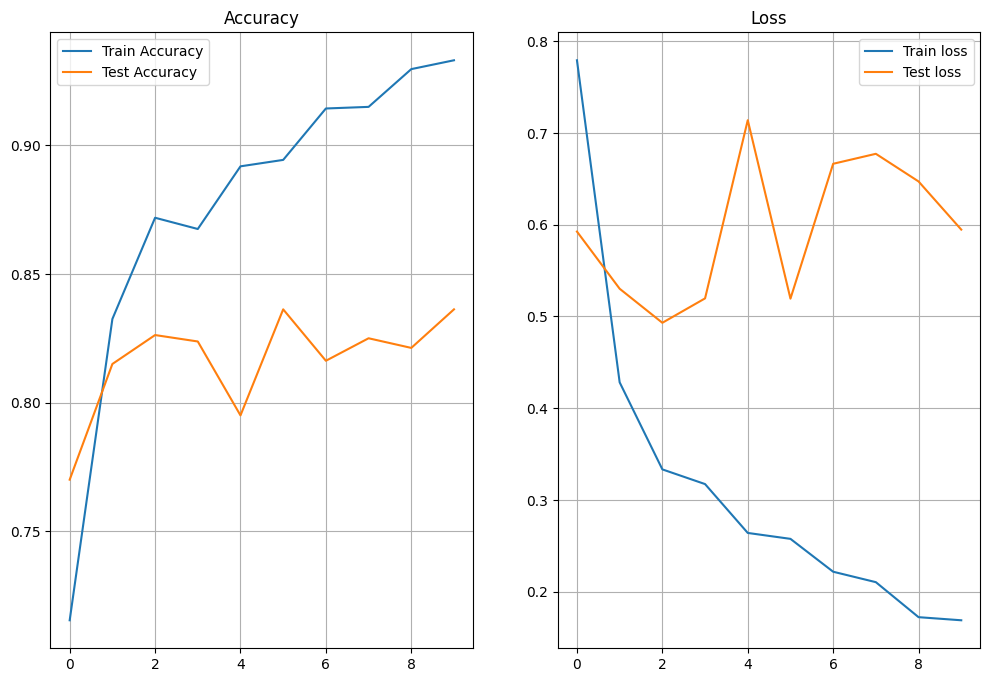

In [70]:
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'] , label = "Train Accuracy")
plt.plot(hist.history['val_accuracy'] , label = "Test Accuracy")
plt.grid()
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(hist.history['loss'] , label = "Train loss")
plt.plot(hist.history['val_loss'] , label = "Test loss")
plt.grid()
plt.legend()
plt.title("Loss")

# Evaluate the model

In [71]:
model.evaluate(test_dataset)

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.8429 - loss: 0.4628


[0.5194457769393921, 0.8362500071525574]

In [72]:
test_sample_images = []
test_sample_labels = []
count = 0
for image , label in test_dataset.take(1):
  if count == 25:
    break
  test_sample_images.append(image)
  test_sample_labels.append(label)
  count += 1

In [73]:
predictions = model.predict(test_sample_images)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_369
Received: inputs=('Tensor(shape=(32, 128, 128, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [74]:
predicted_labels = [np.argmax(i) for i in predictions]
real_labels = [np.argmax(i) for i in test_sample_labels[0]]

print(predicted_labels)
print(real_labels)

[5, 3, 1, 7, 4, 1, 4, 7, 3, 6, 3, 0, 3, 4, 4, 7, 2, 1, 6, 3, 5, 3, 0, 6, 5, 6, 3, 1, 4, 5, 7, 2]
[2, 3, 1, 7, 4, 0, 4, 6, 3, 6, 3, 0, 3, 4, 4, 7, 2, 1, 6, 3, 5, 3, 0, 6, 5, 6, 3, 0, 4, 5, 7, 5]


# Original classes

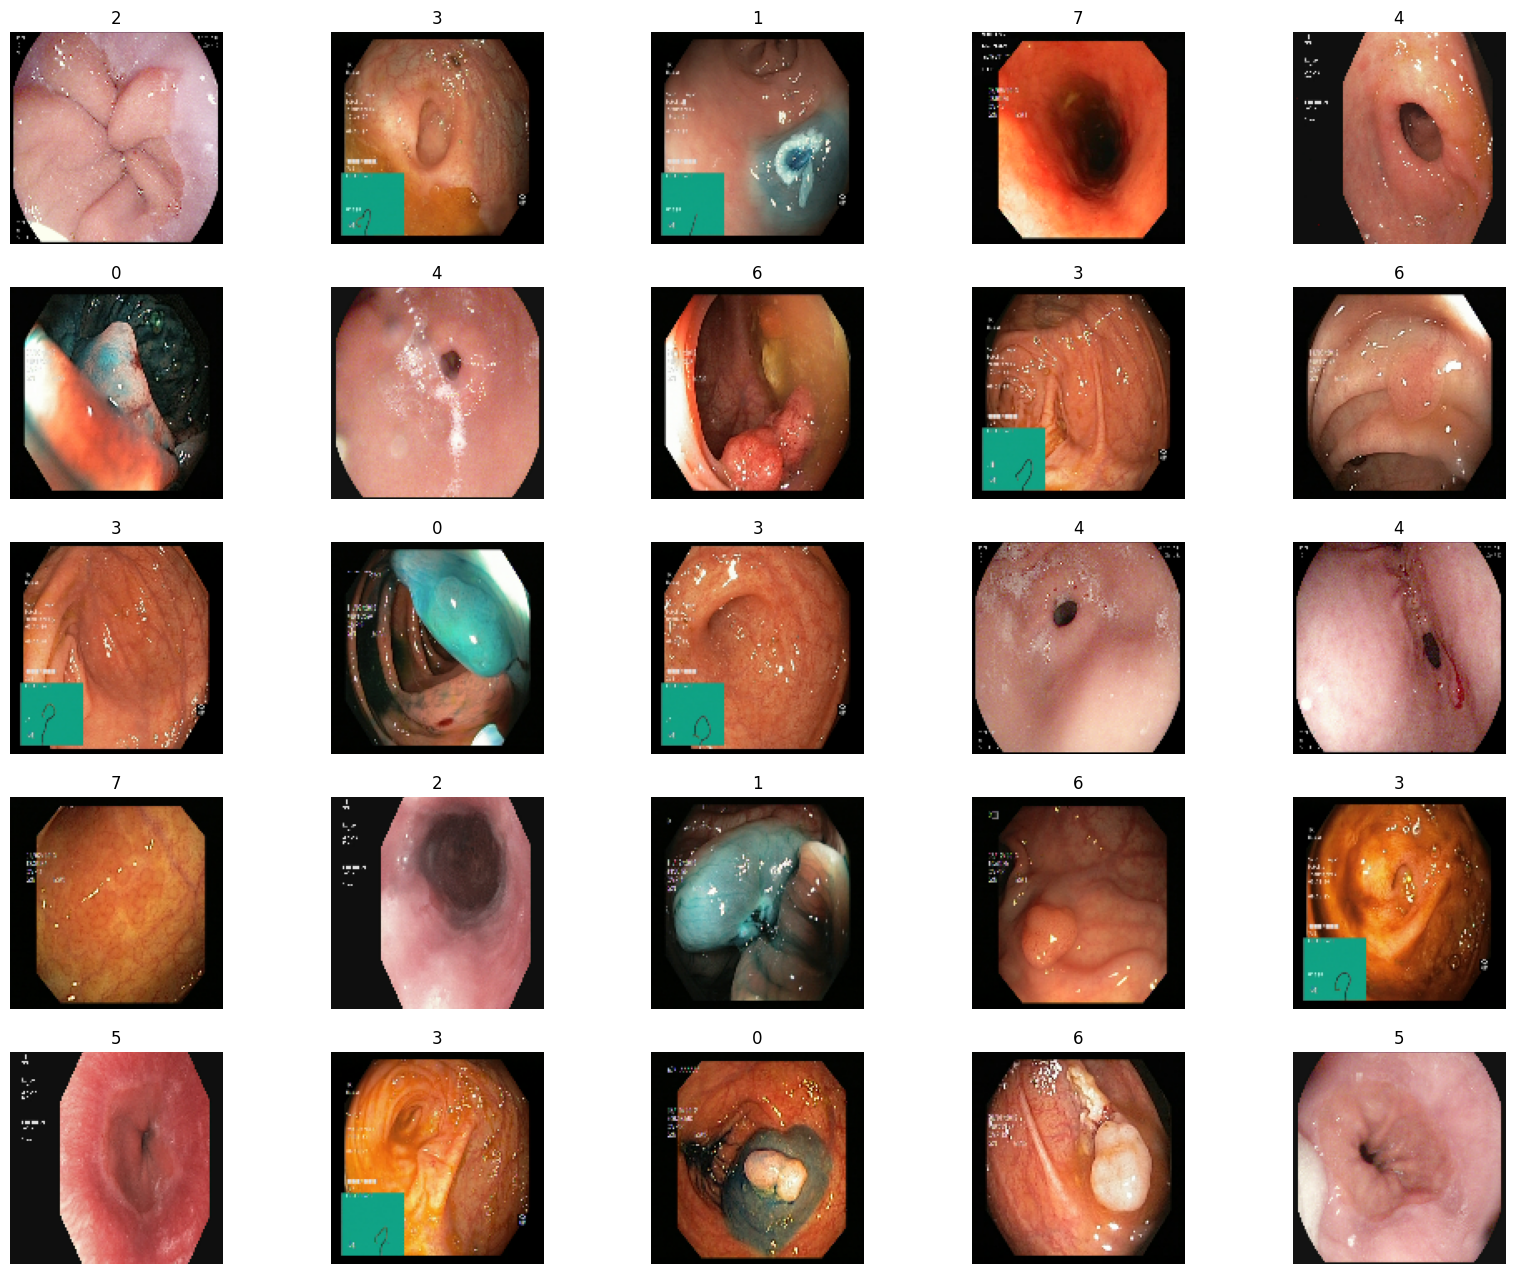

In [79]:
plt.figure(figsize = (20,16))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(test_sample_images[0][i].numpy().astype("uint8"))
  plt.title(np.argmax(test_sample_labels[0][i]))
  plt.axis("off")
plt.show()

# Predicted classes

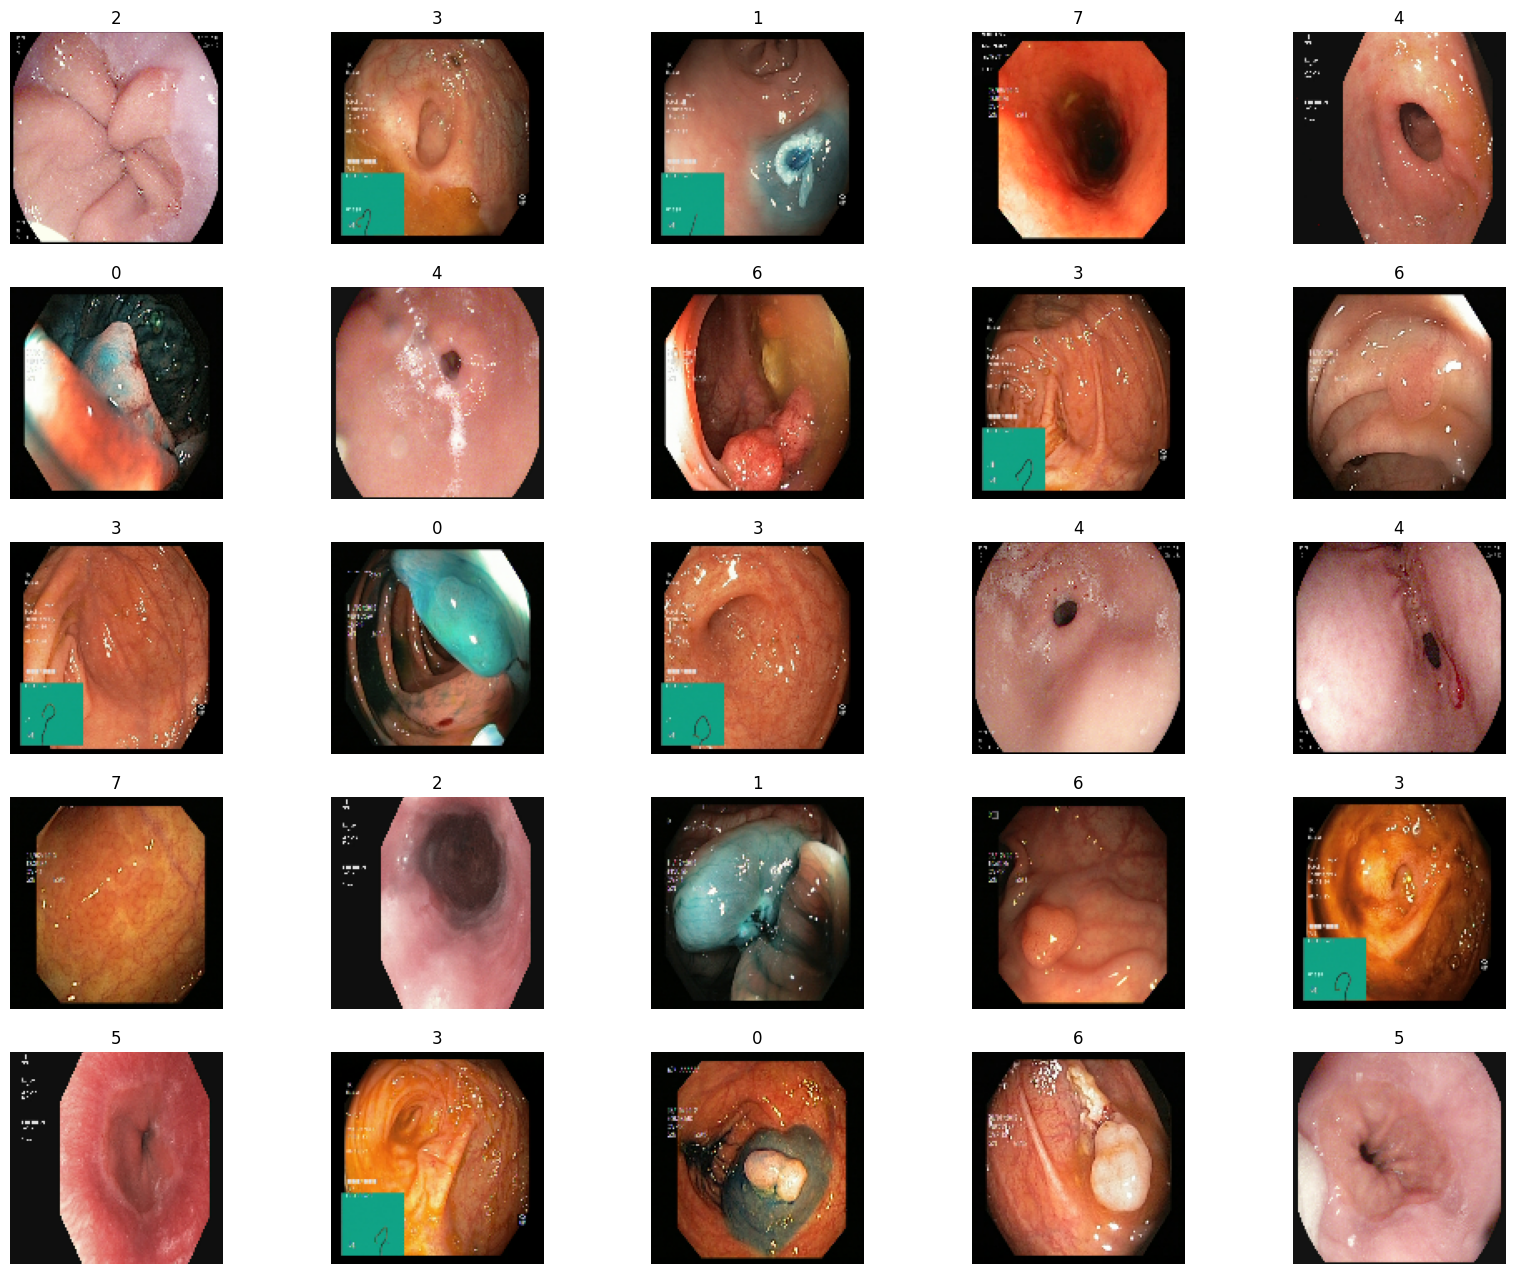

In [80]:
plt.figure(figsize = (20,16))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(test_sample_images[0][i].numpy().astype("uint8"))
  plt.title(real_labels[i])
  plt.axis("off")
plt.show()

# Saves the trained model

In [81]:
path = '/content/drive/MyDrive/MyModels.kvasiracc82.h5'
model.save(path)

# Conclusion

There were 8 classes in this dataset. The model showed very good metrics for its architecture, there were not too many trainable weights.I think we have successfully handled the dataset.

I'll probably update this notebook in the future, but that's not for sure :)